## **P06 - Détecter des faux billets**

### **Table des matières**  
  
[**1. Mission 0 - présentation des données**](#1-mission-0---présentation-des-données)
- [**1.1 Analyse univariée**](#11-analyse-univariée)  
- [**1.2 Analyse bivariée**](#12-analyse-bivariée)
    - [1.2.1. Aperçu](#o-121-aperçu)  
    - [1.2.2. Ajustement linéaire](#o-122-ajustement-linéaire)  
    - [1.2.3. Dépendance non-linéaire](#o-123-dépendance-non-linéaire)
    
[**2. Mission 1 - PCA**](#2-mission-1---pca)
- [**2.1 PCA**](#21-pca)
    - [2.1.1 Eboulis des valeurs propres](#o-211-eboulis-des-valeurs-propres)  
    - [2.1.2 Cercle des corrélations](#o-212-cercle-des-corrélations)  
    - [2.1.3 Individus et plans factoriels](#o-213-individus-et-plans-factoriels)  
    - [2.1.4 Analyse et contribution](#o-214-analyse-et-contribution)    
- [**2.2 kPCA**](#22-kpca)
    
[**3. Mission 2 - classification**](#3-mission-2---classification)
- [**3.1 Algorithme de classification**](#31-algorithme-de-classification)  
- [**3.2 Visualisation**](#32-visualisation)
    
[**4. Mission 3 - modélisation**](#4-mission-3---modélisation)
- [**4.1 Régression logistique**](#41-régression-logistique)
    - [4.1.1 Dataset](#o-411-dataset)  
    - [4.1.2 Estimateur et entraînement](#o-412-estimateur-et-entraînement)
- [**4.2 Test du modèle**](#42-test-du-modèle)
    - [4.2.1 Utilisation](#o-421-utilisation)  
    - [4.2.2 Evaluation](#o-422-evaluation)  
    - [4.2.3 Utilisation in vivo](#o-423-utilisation-in-vivo)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.utils
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import statistics
import math

from scipy.stats import pearsonr
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn import decomposition, preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import  DBSCAN
from kneed import KneeLocator


import random
import datetime as dt

In [3]:
# importation des données
data = pd.read_csv('notes.csv')

In [4]:
yeux = '.now'

plt.style.use('bmh')
mpl.rcParams['axes.edgecolor'] = 'lightslategray'
mpl.rcParams['figure.facecolor'] = 'lightgrey'

tps_ss = dt.datetime.now()
if (tps_ss.hour, tps_ss.minute) < (7, 00) or (tps_ss.hour, tps_ss.minute) > (21, 20) or yeux == 'now':
    plt.style.use('dark_background')

#### [**1. Mission 0 - présentation des données**](#table-des-matières)   
  
Rapide aperçu sur un éventuel nettoyage:  
- structure des données  
- présence de valeurs NaN  
- présence de valeurs non significatives

In [5]:
# structure des données
data.shape

(170, 7)

In [6]:
data.head(1)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83


Données de taille modeste à 7 variables: une variable booléenne et 6 variables de type float  
=> nous devons avoir soient des booléens pour le premier paramètre soient des flottants pour tous les autres. 

In [7]:
# présence de NaN?
data.isna().any().any()

False

In [8]:
# présence de valeurs non significatives?
data.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

=> Toutes les variables sont conformes.  
Au passage, petits changements de nom de colonnes.

In [9]:
data.columns = ['contrefait', 'diagonale', 'hauteur_gc', 'hauteur_dt', 'marge_inf', 'marge_sup', 'largeur']

##### [**1.1 Analyse univariée**](#table-des-matières)  
    
Représentations graphiques des variables "flottantes".  
Nous les affichons deux par deux sur un même graphique puisque que des variables ont même ordre de grandeur, cela nous permetra également de voir comment elles se chevauchent.

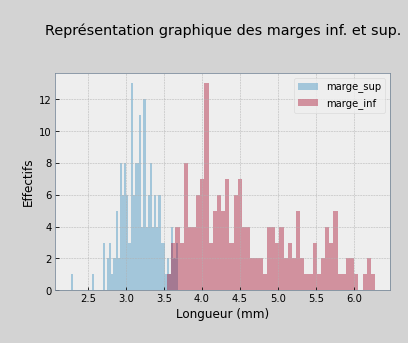

In [10]:
# Couple des marges
fig, ax = plt.subplots()
ax.hist(data.marge_sup, alpha = .4, bins = 50, label = "marge_sup")
ax.hist(data.marge_inf, alpha =.4, bins = 50, label = "marge_inf")
ax.set_xlabel('Longueur (mm)\n')
ax.set_ylabel('\nEffectifs')
ax.legend(loc = 1)
ax.set_title('\nReprésentation graphique des marges inf. et sup.\n\n')
fig.savefig('graphique_marges_inf_sup', dpi = 500)

Les deux marges n'évoluent sur les mêmes valeurs donc l'impression n'est pas centré entre les bords inférieur et supérieur.

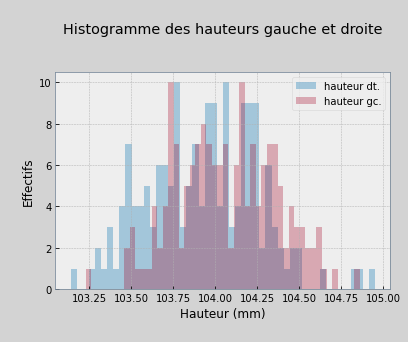

In [11]:
# Couple des hauteurs
fig, ax = plt.subplots()
ax.hist(data.hauteur_dt, alpha = .4, bins = 50, label = "hauteur dt.")
ax.hist(data.hauteur_gc, alpha =.3, bins = 50, label = "hauteur gc.")
ax.set_xlabel('Hauteur (mm)\n')
ax.set_ylabel('\nEffectifs')
ax.legend(loc = 1)
ax.set_title('\nHistogramme des hauteurs gauche et droite\n\n')
fig.savefig('graphique_hauteurs_dt_gc', dpi = 500)

Beaucoup de disparités entre les deux hauteurs et d'irrégularité intra-groupe. Est-ce une caractéristique de conception, un caractère d'une nature frauduleuse..?

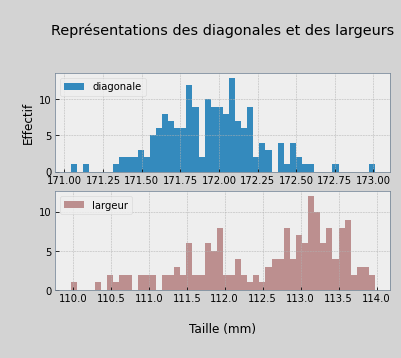

In [12]:
# graphes de "diagonale" et "largeur"
plt.subplot(2, 1, 1)
plt.hist(data.diagonale, bins = 50)
plt.ylabel('\nEffectif')
plt.legend(['diagonale'], loc = 2)
plt.title("\nReprésentations des diagonales et des largeurs\n\n")

plt.subplot(2, 1, 2)
plt.hist(data.largeur, bins = 50, color = 'rosybrown')
plt.xlabel('\nTaille (mm)\n')
plt.legend(['largeur'])

plt.savefig('graphique_largeur_diagonale', dpi = 500)

La distribution de la diagonale est plus intuitive puisiqu'elle s'apparente (grossièrement) à une loi normale par contre, la largeur des billets reprend le comportement erratique des autres variables.

Calcul des mesures de tendances centrales, de dispersion et de forme.  
Représentation graphique.

In [13]:
# initialisation et calcul des mesures
stat_data = pd.DataFrame(columns = data.columns[1:],  data = data.describe())

Nous transposons le df et rajoutons le mode, skew et kurt.

In [14]:
# calcul des mesures de forme pour les colonnes de flottants
for variable in data.columns[1:]:
   stat_data.loc['skewness', variable] = data[variable].skew()
   stat_data.loc['kurtosis', variable] = data[variable].kurtosis()

In [15]:
# transposée du df et suppression d'une colonne
stat_data = stat_data.T
stat_data.drop('count', axis = 1, inplace = True)

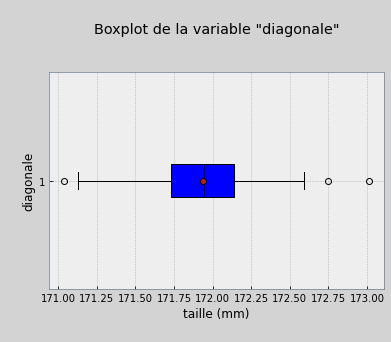

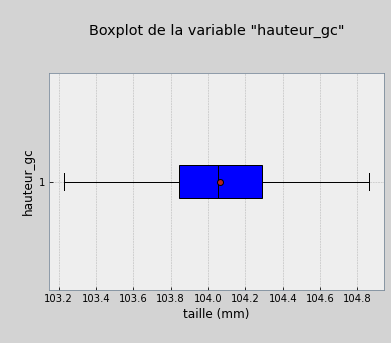

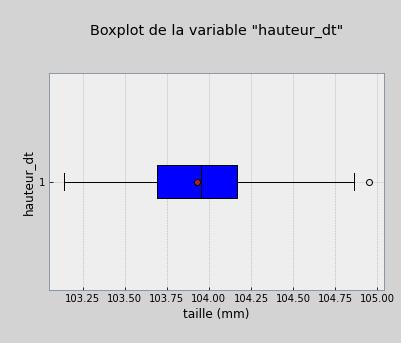

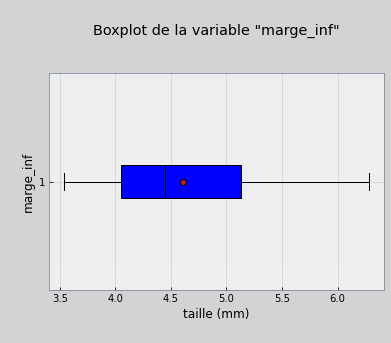

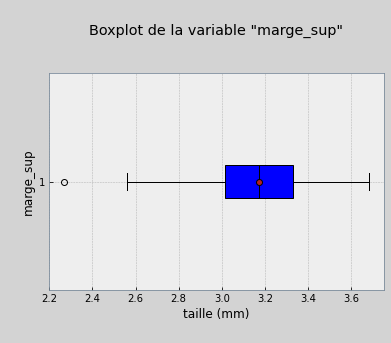

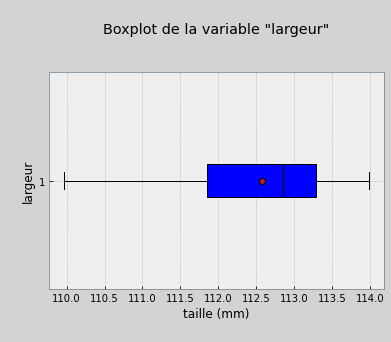

In [16]:
# représentation graphique: boxplot

# paramètres d'affichage du boxplot
medianprops = {'color':"black"}
meanprops = {
            'marker':'o',
            'markeredgecolor':'black',
            'markerfacecolor':'firebrick'
            }

# graphes pour chaque variable pour pb de grandeur de mesures
for variable in data.columns[1:]:
    plt.boxplot(
        data[variable],
        showfliers = True,
        medianprops = medianprops,
        vert = False,
        patch_artist = True,
        showmeans = True,
        meanprops = meanprops
    )
    plt.ylabel('\n{}'.format(variable))
    plt.xlabel('taille (mm)\n')
    plt.title('\nBoxplot de la variable "{}"\n\n'.format(variable))
    plt.savefig('boxplot_variable_flottante', dpi = 500)
    plt.show()

Observations:  
- très peu voire absence d'outliers;
- la distribution de "hauteur_gc" est bien smétrique par rapport à sa médiane et doit certainement suivre une loi normale;  
- à première vue, "marge_sup" ne semble pas non plus avoir de défaut de normalité mais la présence d'un outlier dans les valeurs inférieures doit perturber la symétrie réelle de sa distribution;  
- toutes les autres variables possèdent des asymétries marquées voire importantes pour certaines comme par ex. "marge_inf" et "largeur";  
- il est aussi intéressant de constater que la marge supérieure des billets de l'échantillon a été imprimé de façon bien plus régulière que la marge inférieure, regardons leur densité.

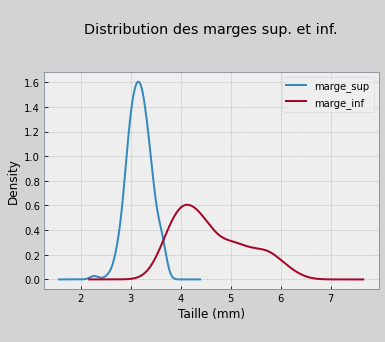

In [17]:
data.marge_sup.plot(kind = 'density')
data.marge_inf.plot(kind = 'density')
plt.legend()
plt.xlabel('Taille (mm)\n')
plt.title('\nDistribution des marges sup. et inf.\n\n')
plt.show()

En effet, la distrbution de marge_sup suit une loi normale tandis que la marge inf. présente un défaut de normalité, est bimodale et a une asymétrie marquée.

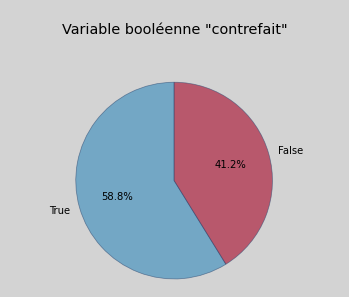

In [18]:
labels = data.contrefait.unique()
size = data.contrefait.value_counts()
wp = {'linewidth':0.75, 'edgecolor':'#2F4C73', 'alpha':.6}

plt.pie(
    size,
    labels = labels,
    autopct = '%1.1f%%',
    shadow = False,
    startangle = 90,
    wedgeprops = wp)
plt.axis('equal')
plt.title('\nVariable booléenne "contrefait"\n\n')
plt.savefig('variable_bool_piechart', dpi = 500)
plt.show()

A peine plus de 40% des billets de l'échantillon sont sont vrais.

##### [**1.2 Analyse bivariée**](#table-des-matières)  
  
##### [o 1.2.1. Aperçu](#table-des-matières)

Text(0.5, 1.0, '\n Analyse des corrélations entre les variables\n\n')

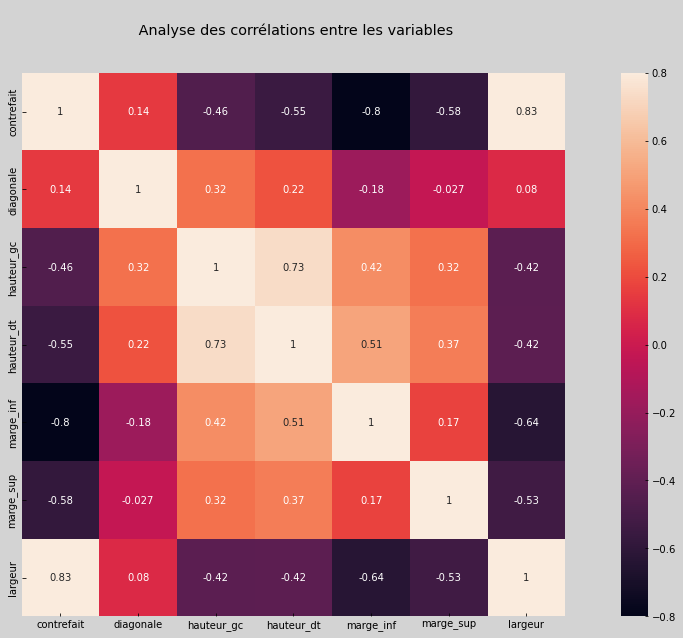

In [19]:
# heatmap de corrélations de Data
mat_corr = data.corr()
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(mat_corr, vmax = .8, square = True, annot = True)
plt.title('\nAnalyse des corrélations entre les variables\n\n')

- les variables "contrefait" et "largeur" sont fortement corrélées;  
- sans surprise, on retrouve une relation de corrélation entre les deux hauteurs mais ce qui est surprenant est que leur coefficient ne soit pas davantage proche de 1;  
- une corrélation négative relie "contrefait" et "marge_inf".

Text(0.5, 1.0, '\nScatterplots des variables\n\n')

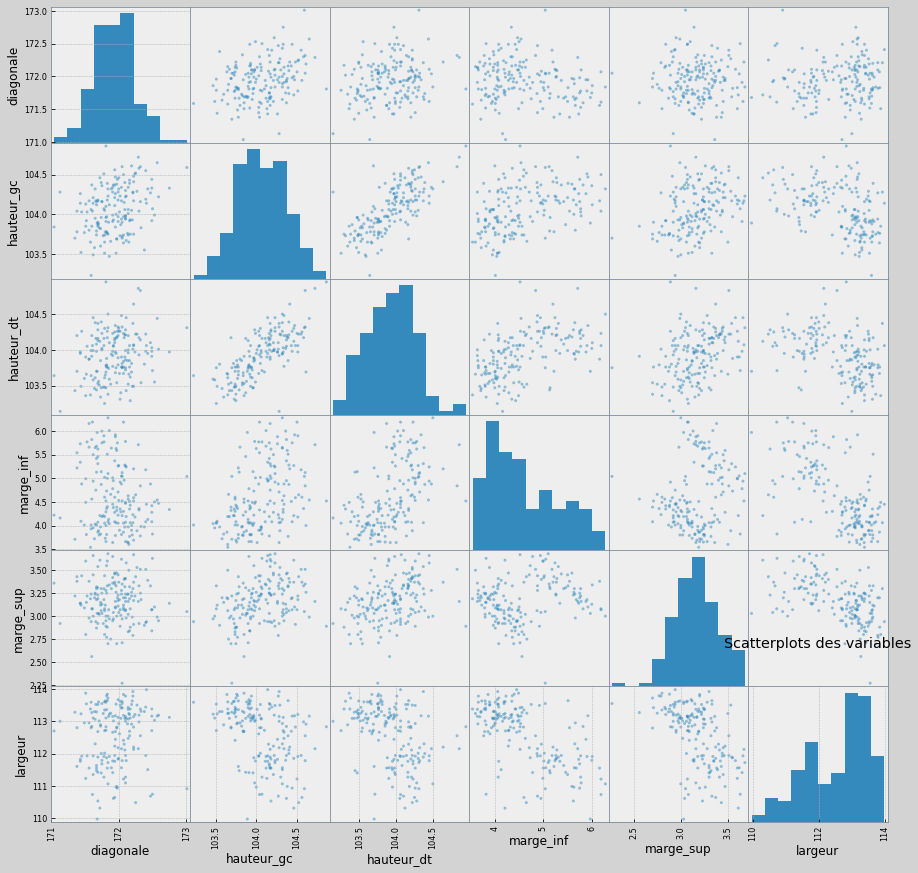

In [20]:
# mini-diagramme de dépendance entre variables
pd.plotting.scatter_matrix(data.drop('contrefait', axis =1), figsize = (15,15))
plt.title('\nScatterplots des variables\n\n')

- hauteur_gc et hauteur_dt ont une dépendance linéaire positive;  
- marge_inf, marge_sup, hateur_dt et hauteur_gc présentent des dépendances non-linéaires avec la variable"largeur".

##### [o 1.2.2. Ajustement linéaire](#table-des-matières)

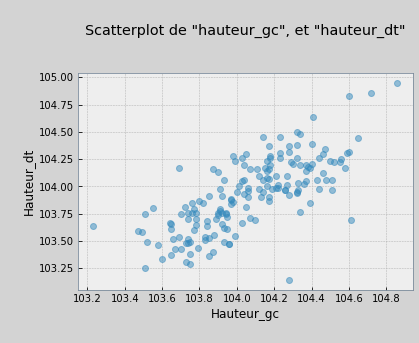

In [21]:
# scatterplot
plt.plot(data.hauteur_gc, data.hauteur_dt, 'o', alpha = 0.5)
plt.title('\nScatterplot de "hauteur_gc", et "hauteur_dt"\n\n')
plt.xlabel("Hauteur_gc\n")
plt.ylabel("\nHauteur_dt")
plt.savefig('scatterplot_hauteurgc_hauteurdt', dpi = 500)
plt.show()

In [22]:
# préparation des données
x = np.array(data.hauteur_gc)
y = np.array(data.hauteur_dt)

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [23]:
# phase d'initialisation + adaptation aux données
model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [24]:
# phase de prédiction de la modélisation
y_predit = model.predict(x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


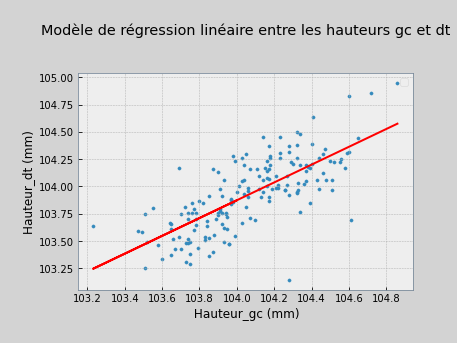

In [25]:
# graphe du modèle + observations
plt.scatter(x, y, s = 10)
plt.plot(x, y_predit, color = 'r')
plt.xlabel("Hauteur_gc (mm)\n")
plt.ylabel("\nHauteur_dt (mm)")
plt.title("\nModèle de régression linéaire entre les hauteurs gc et dt\n\n")
plt.savefig('modele_regression_lin_hauteur_gc_dt', dpi = 500)
plt.show()

In [26]:
# phase d'évaluation
rmse = mean_squared_error(y, y_predit)
r2 = r2_score(y, y_predit)

In [27]:
# les valeurs caractéristiques du modèle
print("Pente du modèle: ", model.coef_)
print("Ordonnée à l'origine: ", model.intercept_)
print("Racine de l'erreur quadratique moyenne: ", rmse)
print('R² = ', r2)

Pente du modèle:  [[0.81515997]]
Ordonnée à l'origine:  [19.09739247]
Racine de l'erreur quadratique moyenne:  0.05016868422625505
R² =  0.5393290660706198


Le coefficient de détermination, très différent de 1, n'est pas très qualitatif => Nous allons procéder à un test afin de pouvoir, au moins, qualifier la relation entre les deux hauteurs.

Test de dépendance entre les deux hauteurs.  
  
- H0: les deux variables sont indépendantes  
- H1: les deux variables sont liées  
- risque  d'erreur alpha = 1%

- méthode : coefficient de Pearson  -> sensible aux outliers or la variable hauteur_dt en possède (cf boxplot ci-dessus)  
=> nous commençons par créer une variable alternative sans outlier "hauteur_dt_":  
Etapes intermédiares:  
    - fonction describe pour récupérer les quantiles de la variable afin de calculer la distance inter-quantile;  
    - calcul des distances à prendre en compte (Q_1/3 +/- 1.5 IQ) pour repérer les outliers;  
    - création d'une variable "propre";  
    - calcul du coefficient de Pearson.

In [28]:
# distance interquantile
data_stat = data.hauteur_dt.describe()
iq = data_stat['75%'] - data_stat['25%']

In [29]:
# calcul des bornes du domaine de définition
dist_outlier = 1.5 * iq

In [30]:
# récupération des index des outliers et création de la variable propre
outlier = data.hauteur_dt[(data.hauteur_dt < data_stat['25%'] - dist_outlier) | (data.hauteur_dt > data_stat['75%'] + dist_outlier)].index
hauteur_dt_ = data.hauteur_dt.drop(outlier)

Ensuite, il nous faut aussi créer une variable alternative pour hauteur_gc ayant un/des éléments en moins égalant le nombre d'outliers de "hauteur_dt", le calcul du coefficient de Pearson ayant besoin de variables de mêmes longueurs. Le choix de ses valeurs est fait au hasard à l'aide d'une fonction de Python.

In [31]:
# création d'une "hauteur_gc" alternative
if len(outlier) > 0 :
    idx_ = data[data.hauteur_gc.isin(random.choices(data.hauteur_gc, k = len(outlier)))].index
    idx = random.sample(tuple(idx_), len(outlier)) # re-sélection en cas de multiples index partageant la même valeur
    hauteur_gc_ = data.hauteur_gc.drop(idx)

In [32]:
# calcul du coefficient de Pearson
print('Coeff. de Pearson =', pearsonr(hauteur_gc_, hauteur_dt_)[0])
print('P-value =', pearsonr(hauteur_gc_, hauteur_dt_)[1])

Coeff. de Pearson = 0.5380492178231535
P-value = 4.557955970087183e-14


=> p-value << alpha;  
=> H0 est rejetée;  
=> par extension, nous considérons les variables "hauteur_gc" et "hauteur_dt" corrélées avec un risque d'erreur de 1%;  
=> la régression linéaire n'est pas un modèle adapté pour modéliser la relation de dépendance entre les deux hauteurs.

##### [o 1.2.3. Dépendance non-linéaire](#table-des-matières)  
  
Rappel: une relation de dépendance a été estimée entre "largeur" et les variables "marge_inf", "marge_sup", "hauteur_dt" et "hauteur_gc".

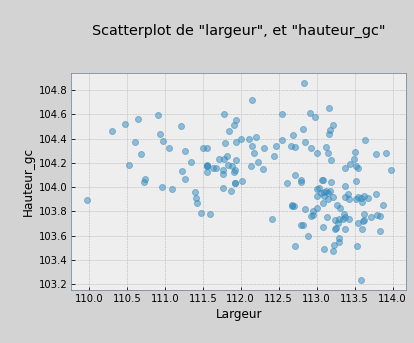

In [33]:
# scatterplot de largeur et hauteur_gc
plt.plot(data.largeur, data.hauteur_gc, 'o', alpha = 0.5)
plt.title('\nScatterplot de "largeur", et "hauteur_gc"\n\n')
plt.xlabel("Largeur\n")
plt.ylabel("\nHauteur_gc")
plt.savefig('scatterplot_hauteurgc_largeur', dpi = 500)
plt.show()

Le scatterplot met en évidence une répartition des données en deux amas distincts dont la nature n'est pas linéaire.  
  
Posons l'hypothèse de nullité où la largeur d'un billet est indépendant de la hauteur du son bord gauche et l'hypothèse alternative liant les deux variables. La statistique de test est le calcul de leur covariance.  
La condition de validation de H0 est cov(largeur, hauteur_gc) ~ 0.

In [34]:
# covariance entre la largeur et la hauteur à droite
np.cov(data.largeur, data.hauteur_dt)[0][1]

-0.12759744517925467

=> cov(largeur, hauteur_gc) > 0 => rejet de HO  
Remarque: la covariance des deux variables:  
- restent basses => le "degré" de dépendance est faible;  
- et est négatives => la largeur et la hauteur de la tranche gauche d'un billet sont anti-corrélées;  
Ce deux observations ne sont pas inuitives.

#### [**2. Mission 1 - PCA**](#table-des-matières)

In [35]:
# fonction pour projection sur un plan factoriel avec % d'inertie
def display_factorial_plane(X_projected, n_comp, pca, axis_ranks, labels = None, alpha = 1, illustrative_var = None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure       
            fig = plt.figure(figsize = (7,6))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha = alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha = alpha, label = value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y - .5, labels[i],
                              fontsize = '15', ha = 'center', va = 'center') 

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color = 'grey', ls = '--')
            plt.plot([0, 0], [-100, 100], color = 'grey', ls = '--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)\n'.format(d1+1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('\nF{} ({}%)'.format(d2+1, round(100 * pca.explained_variance_ratio_[d2], 1)))

            plt.title("\nProjection des individus sur F{} et F{}\n\n".format(d1 + 1, d2 + 1))
            plt.show(block = False)

In [36]:
# fonction pour présenter le cercle des corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels = None, label_rotation = 0, lims = None):
    for d1, d2 in axis_ranks: # on affiche les 3 premiers plans fatoriels => 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize = (7,6))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles = 'xy', scale_units = 'xy', scale = 1, color = "grey")
            else:
                lines = [[[0,0], [x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes = ax, alpha = .1, color = 'black'))

            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]]. T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize = '14', ha = 'center', va = 'center', rotation = label_rotation, color = "blue", alpha = 0.5)

            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor = 'none', edgecolor = 'b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color = 'grey', ls = '--')
            plt.plot([0, 0], [-1, 1], color = 'grey', ls = '--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)\n'.format(d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('\nF{} ({}%)'.format(d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)))

            plt.title("\nCercle des corrélations sur F{} et F{}\n\n".format(d1 + 1, d2 + 1))
            plt.show(block = False)

In [37]:
# fonction pour représenter l'éboulis des valeurs propres
def display_scree_plot(pca) :
    scree = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(
        np.arange(len(scree)) + 1,
        scree.cumsum(),
        c = "darkred",
        marker='o'
    )
    plt.xlabel("Rang de l'axe d'inertie\n")
    plt.ylabel("\n% d'inertie")
    plt.title("\nEboulis des valeurs propres\n\n")
    plt.show(block = False)

##### [**2.1 PCA**](#table-des-matières)  
  
##### [o 2.1.1 Eboulis des valeurs propres](#table-des-matières)

In [38]:
# préparation des données
x = data.values
ind = data.index

# centrage et réduction : même si toutes les unités sont =
std_scale = preprocessing.StandardScaler().fit(x)
x_scaled = std_scale.transform(x)

In [39]:
# choix du nombre de composantes principales
n_comp = min(data.shape[0] + 1, data.shape[1])

# calcul des composantes principales
pca = decomposition.PCA(n_components = n_comp).fit(x_scaled)
x_projected = pca.transform(x_scaled)

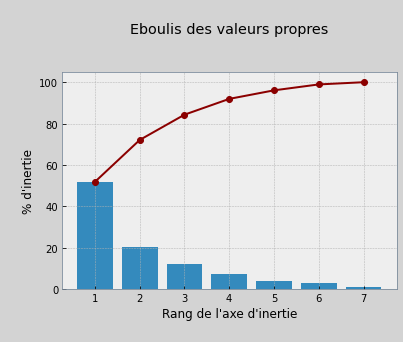

In [40]:
# éboulis des valeurs propres
display_scree_plot(pca)

Nous estimons les deux premières composantes captant plus de 70% de l'inertie totale de Data. Le premier plan factoriel devrait être suffisant pour les projections mais nous utiliserons tout de même la 3ème composante principale et ainsi obtenir plus de 80% de l'inertie.

##### [o 2.1.2 Cercle des corrélations](#table-des-matières)

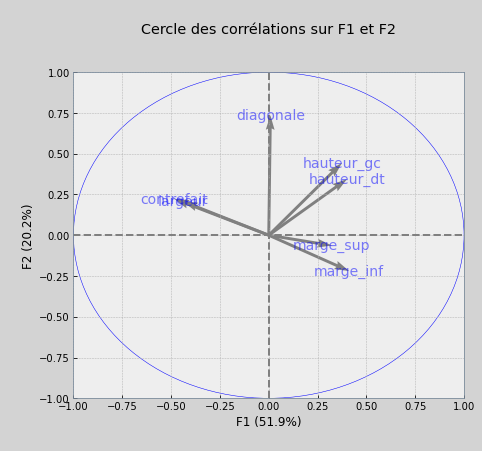

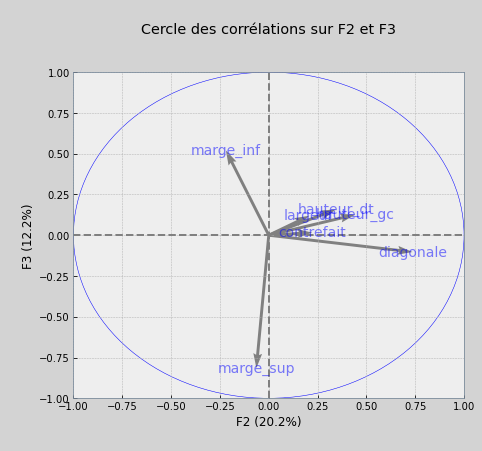

<Figure size 432x288 with 0 Axes>

In [41]:
# extraction des données
pcs = pca.components_

# cercle des corrélation : 1er et 2e plan
display_circles(pcs, 3, pca, [(0, 1), (1, 2)], labels = data.columns, label_rotation = 0, lims = None)
plt.savefig('cercle_correlation_f1_f2_f3', dpi = 500)

- Les trois premières composantes principales représentent exactement 84.3% de l'inertie totale.  
  
- Qualités remarquables:  
    -- "diagonale" et surtout "marge_sup" sont très bien représentées sur ces plans factoriels => minimum 75% de ces deux variables sont exprimés à l'aide des des composantes principales de leur plan respectif => il n'est pas déplacé de pouvoir interpréter leur angle et affirmer que ces deux variables sontr très faiblement corrélées entre elles;
- Corrélations les plus importantes:  
    -- "diagonale" est parfaitement corrélée à F2 mais pas du tout avec F1 => VP de F1 = 0, on retrouve un fort degré de corrélation sur le 2e plan ainsi qu'un petit coefficient négatif de corrélation avec F3 de moins de .125;  
    -- "marge_sup" est géométriquement complémentaire à "diagonale", ces deux varibles sont donc indépendantes, le coefficient de corrélation est négatif et élevé avec F2 et bas pour le coeff. selon F3;  

- Les autres variables:  
    -- leur projection sont trop mauvaises pour pouvoir tirer des observations pertinentes;  
- Faits notables:  
    -- on retrouve une interprétation des observations de la heatmap en début d'analyse bivariée : dans le 1er PF, "contrefait" et "largeur" sont colinéaires mais n'étant qu'à moitié représenté sur ce plan, nous ne nous prononcerons pas davantage sur leur degré de corrélation;

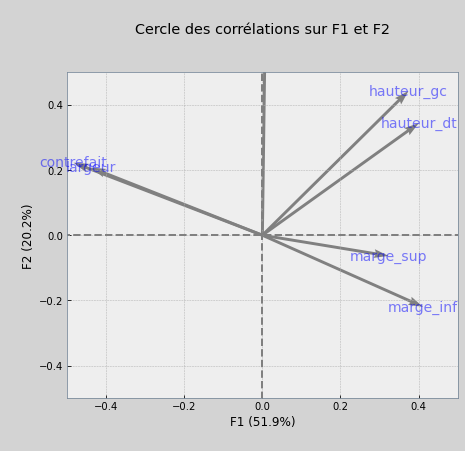

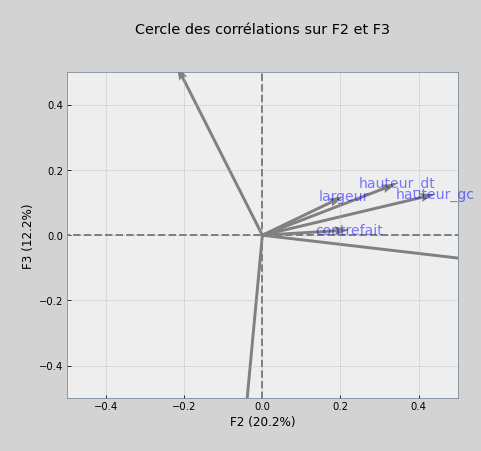

<Figure size 432x288 with 0 Axes>

In [42]:
# zoom sur les origines du 1er plan
cercle_corr = display_circles(pcs, 3, pca, [(0, 1), (1, 2)], labels = data.columns, label_rotation = 0, lims = (-.5, .5, -.5, .5))
plt.savefig('cercle_correlation_f1_f2_f3_zoom', dpi = 500)

Nous retrouvons le groupe des "mal-projetés" composé des deux hauteurs auquel vienne s'ajouter le 2ème sous-groupe "largeur" et "contrefait" au comportement analogue. Il vaudrait mieux faire une projection dans le 2e plan factoriel tant leur représentation au 1er plan est mauvaise et importe peu d'information.

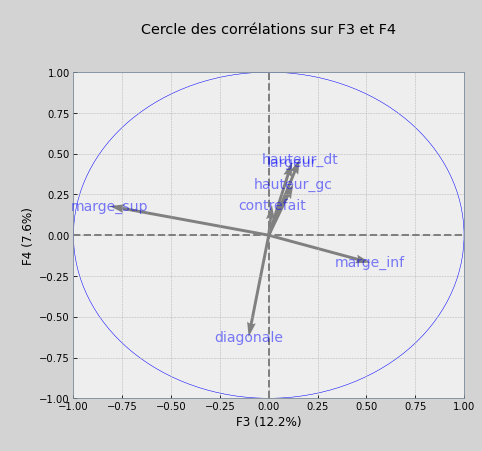

<Figure size 432x288 with 0 Axes>

In [43]:
# cercle des corrélation : 3e du nom
display_circles(pcs, 4, pca, [(2, 3)], labels = data.columns, label_rotation = 0, lims = None)
plt.savefig('cercle_correlation_f3_f4', dpi = 500)

- Le sous-groupe des 4 reste encore sévèrement sous-représenté. Leur degré respectif de corrélation avec F1 est le plus optimale pour leur projection. Nous n'irons pas plus loin dans les composantes principales.  
- Nous nous garderons d'affirmer une relation anticorrélée entre les marges puisque la qualité de la projection de marge_inf n'est pas idéal mais le doute persiste puisque les projections du 2e PF met en évidence l'indépendance de "marge_sup" et "diagonale"" et, ici, "diagonale" et "marge_inf" ont une projection de même qualité.

##### [o 2.1.3 Individus et plans factoriels](#table-des-matières)

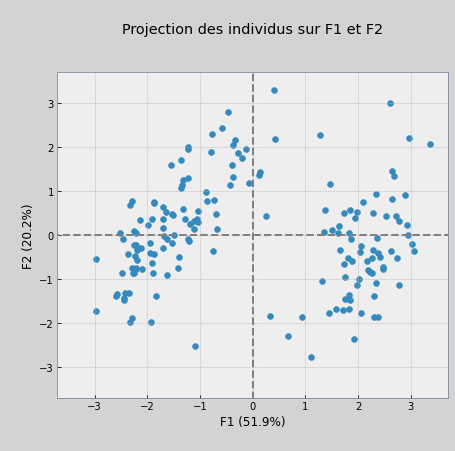

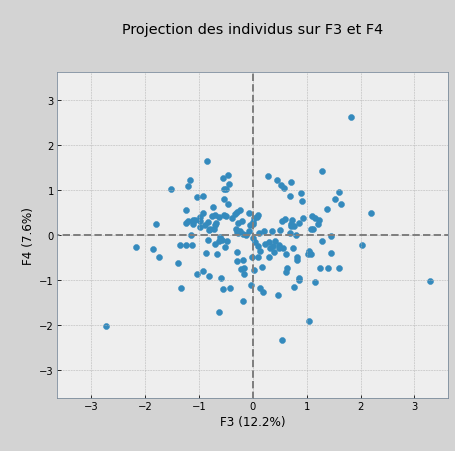

In [101]:
# projection des individus dans les é premiers plans factoriels
display_factorial_plane(x_projected, 4, pca, [(0, 1), (2, 3)], None, 1, None)

- 1er plan factoriel  
    -- mis en évidence de deux amas bien distincts or la variable booléenne ne contribue pas fortement aux deux premières composantes principales => au moins une autre variable contribue à différencier les individus, peut-être "diagonale", la mieux représentée sur ce plan;  
    -- la nature des corrélations de "contrefait" avec les composantes 1 et 2 permet de déduire que tous les individus de l'amas supérieur possède une valeur propre élevé avec cette variable -> l'analyse univariée nous indique que le taux de "True" est majoritaire. Au vue du nombre des individus par amas, le groupe dans les valeurs négatives de F1 est celui des faux billet;  
    -- les vrais billet sont majoritairement caractérisés par leurs marges tandis que les faux, par la largeur;  
    -- le nombre important des individus le long de F2 nous permet de penser que la diagonale est également une caractéristique des faux billets bien qu'elle y contribue moins bien que la largeur;   
- 2e plan:  
    -- 3 individus en périphérique sortent du lot. Cela peut indiquer leur important degré de corrélation avec les deux CP or F3 est fortement déterminé par "marge_sup", un trait des vrais billets => les deux individus proche de F3 (dans la partie inférieure) seraient de vrais billets. Le 3e est équidistant à F3 et or F4 est anticorrélée à 'diagonale' => les traits des vrais et faux billets sont présents donc nous ne pouvons conclure sur sa nature contrefaite mais ces exentricités peuvent aussi signaler la présence de outliers.  
  
Regardons ce que devient la projection des individus en prenant en compte la variable "contrefait" de la bdd.

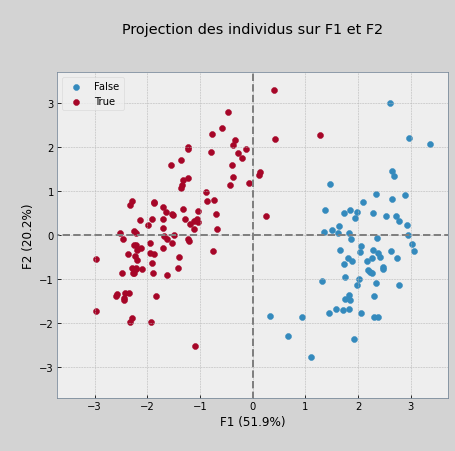

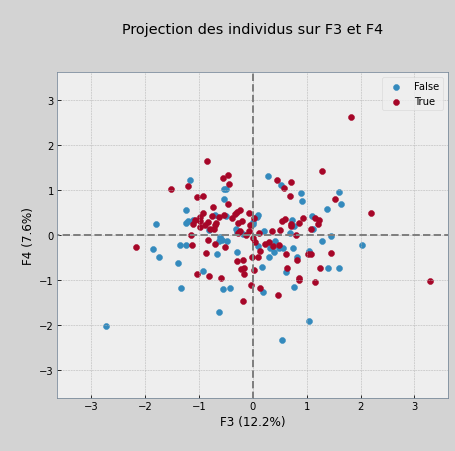

In [45]:
# projection des individus selon les valeurs de la colonne "contrefait"
display_factorial_plane(x_projected, 4, pca, [(0, 1), (2, 3)], None, 1, data.contrefait)

Le raisonnement des premières projections était bon : les deux amas sont différenciés par leur valeur "contrefait".  
Encore une fois, l'amas central n'apporte pas d'information valable, par contre, concernant le 2e plan, une erreur est faite sur l'un des 3 individus or, la logique reste valable de plus, F3 est très fortement corrélée avec la variable marge_sup qui possède un outlier. Il en va de même pour F4 et "sa diagonale" possédant 3 outliers. Devant l'incohérence des 3 individus avec les corrélations des axes, nous pouvons en conclure qu'il s'agit bien de outliers.

##### [o 2.1.4 Analyse et contribution](#table-des-matières)  
  
Nous continuons en exprimant nos données en fonction des 4 premières composantes principales et calculons la contribution et la qualité de représentation de chaque individu.

In [46]:
# expression des individus en fonction des CP
acp_individus = pd.DataFrame(x_projected, columns = ["f" + str(i+1) for i in range(7)])

In [47]:
# expression des individus en fonction des 4 premières CP
acp_ind = acp_individus.iloc[:, :4]

In [48]:
# expression des CP en fonction des variables
acp_variables = pd.DataFrame(pca.components_, columns = data.columns, index = ["f" + str(i+1) for i in range(7)])

In [49]:
# extraction des données pour les 4 premières CP
acp_var = acp_variables[:4]
acp_var

,contrefait,diagonale,hauteur_gc,hauteur_dt,marge_inf,marge_sup,largeur
f1,-0.483270,0.008340,0.373970,0.400426,0.411377,0.323178,-0.438761
f2,0.222327,0.736056,0.442198,0.343709,-0.219424,-0.063437,0.207233
f3,0.016080,-0.102960,0.125689,0.158106,0.519999,-0.814699,0.119216
f4,0.185934,-0.623295,0.314347,0.464670,-0.168770,0.179102,0.449042


Seule la troisième composante principale a une faible corrélation avec la colonne "contrefait" et F1 lui est anticorrélée.

In [50]:
# extraction des inerties de chaque CP
inertie_cp = pca.explained_variance_

In [51]:
# qualité de représentation par CP
rep_f1 = acp_ind.f1/inertie_cp[0]
rep_f2 = acp_ind.f2/inertie_cp[1]
rep_f3 = acp_ind.f3/inertie_cp[2]
rep_f4 = acp_ind.f4/inertie_cp[3]

In [52]:
# qualité de représentation pour les 2 premiers plans
acp_ind['representation_p1'] = rep_f1 + rep_f2
acp_ind['representation_p2'] = rep_f3 + rep_f4

C:\Users\Percent Society\AppData\Local\Temp\ipykernel_9644\2299374988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acp_ind['representation_p1'] = rep_f1 + rep_f2
C:\Users\Percent Society\AppData\Local\Temp\ipykernel_9644\2299374988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acp_ind['representation_p2'] = rep_f3 + rep_f4


In [53]:
# inertie du nuage sur les 2 premiers plans
inertie_p1 = acp_ind.f1.sum() + acp_ind.f2.sum()
inertie_p2 = acp_ind.f3.sum() + acp_ind.f4.sum()

In [54]:
# contribution par individu aux 2 premiers plans
acp_ind['contribution_p1'] = (acp_ind.f1 + acp_ind.f2) / inertie_p1
acp_ind['contribution_p2'] = (acp_ind.f3 + acp_ind.f4) / inertie_p2

In [55]:
acp_ind.head(2)

,f1,f2,f3,f4,representation_p1,representation_p2,contribution_p1,contribution_p2
0,1.268092,2.278191,1.817199,2.636128,1.946607,7.022212,4.990950e+14,-1.179765e+15
1,-2.207379,-0.758887,0.541914,0.309932,-1.136969,1.207560,-4.174649e+14,-2.256688e+14


Les contributions pour chaque plan présentent toutes deux des valeurs négatives ou positives. Naïvement, il est tentant d'en déduire qu'il s'agit de l'expression de la variable "contrefait" qui est corrélée avec la première CP. Comparons le nombre des individus "négatifs" avec la variable booléenne.

In [56]:
# nombre de valeurs négatives dans contribution_p1 et contribution_p2
len(acp_ind[acp_ind.contribution_p1 < 0]),  len(acp_ind[acp_ind.contribution_p2 < 0])

(81, 82)

In [57]:
# nombre de valeurs négatives dans representation_p1 et representation_p2
len(acp_ind[acp_ind.representation_p2 < 0]), len(acp_ind[acp_ind.contribution_p2 < 0])

(85, 82)

In [58]:
# nombre d'individus (contrefait = false)
len(data[data.contrefait == 0])

70

La qualité des représentations et les contributions ne semblent ne pas être des caractères déterminants pour distinguer les vrais des faux billets mais cela peut être dû au fait d'avoir appliquer une méthode dite linéaire or, les faux billets ne sont peut-être pas caractérisés exactement de la même façon, par exemple, s'ils sont issus de différentes imprimeries, les défaults ne seron certainement pas identiques. On peut donc considérer ces individus ne suivant pas un comportement linéaire. Nous allons utiliser une méthode factorielle non-linéaire.

#####  [**2.2 kPCA**](#table-des-matières)  
  
Nous rappellons que les index sont dans 'ind' et que l'ensemble des données est initialement stocké sous la variable x mais nous allons la retravailler pour d'exclure la variable booléene "contrefait" afin de voir si le clustering peut mettre en évidence des dispartiés sans son influence.  
Pour effectuer cette ACP, nous utilisons un noyau gaussien ('rbf') appliquer aux 3 premières composantes principales.

In [59]:
# préparation des données sans contrefaçon
z = data.drop("contrefait", axis = 1).values

In [60]:
# paramétrage du kPCA
k_pca = KernelPCA(
    n_components = 3,
    kernel = 'rbf',
    alpha = .1
)

In [61]:
# application du kPCA aux données
z_kpca = k_pca.fit_transform(z)

In [62]:
# stockage des infos sous forme de df: initialisation
data_kpca = pd.DataFrame()

In [63]:
# récupération des données selon les 3 premières composantes
data_kpca['y'] = ind
data_kpca['cp_1'] = z_kpca[:, 0]
data_kpca['cp_2'] = z_kpca[:, 1]
data_kpca['cp_3'] = z_kpca[:, 2]

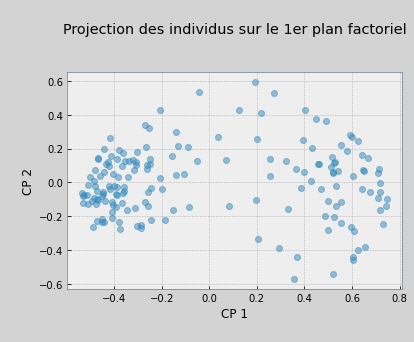

In [64]:
# projection des individus sur les 2 premières CP
plt.plot(data_kpca.cp_1, data_kpca.cp_2, 'o', alpha = 0.5)
plt.title('\nProjection des individus sur le 1er plan factoriel\n\n')
plt.xlabel("CP 1\n")
plt.ylabel("\nCP 2")
plt.savefig('projection_kpca_1er_plan_factoriel', dpi = 500)
plt.show()

Nous retrouvons une répartition des données en deux amas distincts bien que la délimitation soit moins évidente. Néanmoins, l'inertie d'un des deux groupes est plus faible. Nous utilisons Seaborn afin d'appliquer un code couleur et mieux appréhender le comportement des individus.

[Text(0.5, 1.0, '\nProjection kPCA des individus\n\n')]

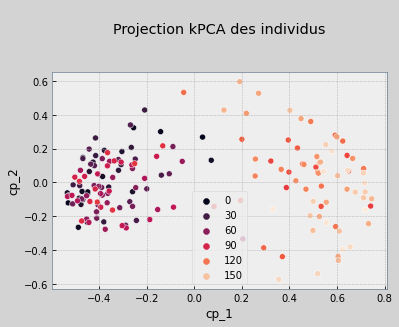

In [65]:
# projection des données kPCAisées sur les 2 premières composantes
sns.scatterplot(
    x = "cp_1",
    y = "cp_2",
    hue = data_kpca.y.tolist(),
    palette = sns.color_palette("rocket", as_cmap = True),
    data = data_kpca
).set(title = "\nProjection kPCA des individus\n\n")

La concentration des individus du cluster de gauche porrait traduire une régularité dans les caractéristiques des individus, signe de vrais billets.  
Nous effectuons la projection dans le 2e plan factoriel.

[Text(0.5, 1.0, '\nProjection kPCA des individus\n\n')]

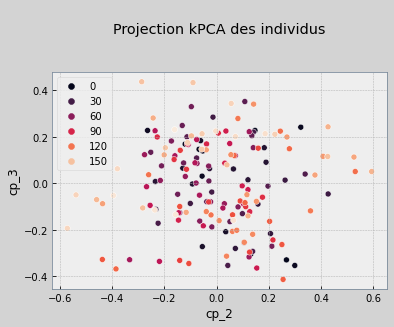

In [66]:
# projection des données kPCAisées sur les 2 dernières composantes
sns.scatterplot(
    x = "cp_2",
    y = "cp_3",
    hue = data_kpca.y.tolist(),
    palette = sns.color_palette("rocket", as_cmap = True),
    data = data_kpca
).set(title = "\nProjection kPCA des individus\n\n")

Comme pour la PCA linéaire, la projection sur le plan (CP2, CP3) n'apporte pas d'information exploitable. Nous efectuons une projection sur le (CP1, CP3).

[Text(0.5, 1.0, '\nProjection kPCA des individus\n\n')]

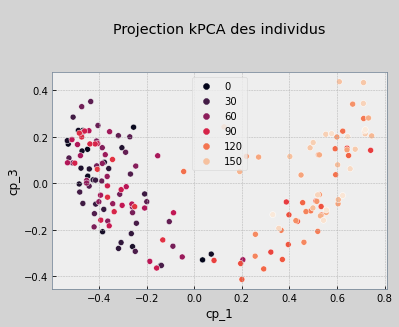

In [67]:
# projection des données kPCAisées sur les 2 premières composantes
sns.scatterplot(
    x = "cp_1",
    y = "cp_3",
    hue = data_kpca.y.tolist(),
    palette = sns.color_palette("rocket", as_cmap = True),
    data = data_kpca
).set(title = "\nProjection kPCA des individus\n\n")

Ce plan met très en avant la bipolarité de l'échantillon. Malgré l'apparente symétrie de cette projection, l'inertie captée par CP 3 reste supérieure pour le cluster de droite de même que l'inertie sur CP 1 est plus importante pour le groupe de gauche. Si l'on reprend les projections sur les deux autres plans, nos sommes tenté de déduire l'ascendance de CP1 à pouvoir différencier les deux groupes et, par extension, les vrais des faux billets.  
Mais pour pouvoir corroborer cette hypothèse, il nous faut vérifier la qualité de représentation des individus et leur contribuition sur F1. A cause de la concentration d'un des clusters, nous utilisons choissisons d'utiliser le premier plan factoriel pour cette étude.

In [68]:
# expression des individus en fonction des 3 premières composantes
kpca_individus = pd.DataFrame(z_kpca, columns = ["f" + str(i+1) for i in range(3)])

In [69]:
# expression des composantes en fonction des variables
#kpca_variables = pd.DataFrame(data = k_pca, columns = k_pca.get_feature_names_out, index = ["f" + str(i+1) for i in range(3)])

#### [**3. Mission 2 - classification**](#table-des-matières)  
##### [**3.1 Algorithme de classification**](#table-des-matières)  
  
Pour rappel, les données sont stockées dans la variable x mais nous en créons un nouveau sans la colonne booléenne "contrefait".   
Ensuite, nous initialisons les paramètres de DBSCAN:  
- min_sample = le nombre de voisins minimal pour pouvoir considérer un amas de voisin comme une cellule pertinente;  
- eps: epsilon, distance maximale pour considérer un point comme étant un voisin;  
- distance euclidienne : type de distance par défaut, conservée.  
  
Puis, nous appliquons le modèle DBSCAN proprement dit.

In [70]:
# préparation des données sans la 1ère colonne 'contrefait'
x_dbscan_ = data.iloc[:, 1:].values
x_dbscan__ = preprocessing.StandardScaler().fit(x_dbscan_)
x_dbscan = x_dbscan__.transform(x_dbscan_)

Nous suivons la convention pour laquelle le minimum de voisins par voisinage = le double de la dimension des données.

In [71]:
# affichae des dimensions des données
x_dbscan.shape

(170, 6)

In [72]:
# nombre minimal de voisins
MinPts = 4

Pour epsilon, nous utilisons une sorte de méthode du coude : nous commençons par calculer toutes les distances entre les points, nous les représentons sur un graphique par triées par ordre croissant et repérons l'ordonné (distance core_voisins) où à lieu une "cassure" de la courbe. Nous abordons deux façons  d'évaluer cette valeur : une visuelle et donc approximative et une seconde à l'aide d'un alogorithme de détection issu du module Kneed.

In [73]:
# calcul des 4 distances core-voisins et sauvegarde des indices
dist_vsn = NearestNeighbors(n_neighbors = MinPts).fit(x_dbscan)
distance, indice = dist_vsn.kneighbors(x_dbscan)

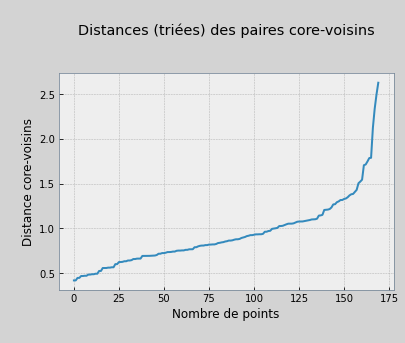

In [74]:
# trie et graphe des distances core-voisins
distance = np.sort(distance, axis = 0)
distance = distance[:, 1]
plt.plot(distance)

plt.xlabel('Nombre de points\n')
plt.ylabel('\nDistance core-voisins')
plt.title('\nDistances (triées) des paires core-voisins\n\n')
plt.savefig('distance_core_voisin', dpi = 500)
plt.show()

La "cassure" semble avoir lieu à la 7ème classe => eps = .55. Nous utilisons la bibliothèque Knee afin de la recherche précise du coude à un alogorithme.

Eps = 1.301974873620101


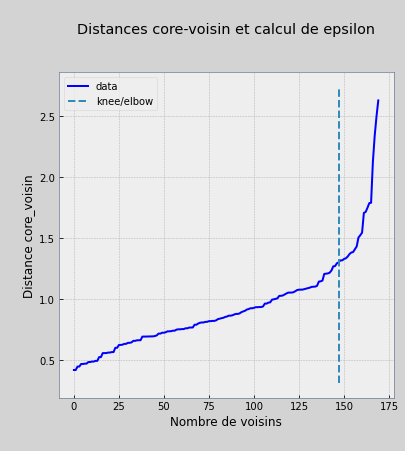

In [75]:
# recherche algorithmique du coude dans les distances core_voisins
d = np.arange(len(distance))
knee = KneeLocator(
    d,
    distance,
    S = 1,
    curve = 'convex',
    direction = 'increasing',
    interp_method = 'polynomial' # algo utilisé
)

# graphique des distances + position du coude
knee.plot_knee()
plt.title("\nDistances core-voisin et calcul de epsilon\n\n")
plt.xlabel("Nombre de voisins\n")
plt.ylabel("\nDistance core_voisin")
plt.savefig('calcul_epsilon', dpi = 500)

print("Eps =", distance[knee.knee])

In [76]:
# affectation de epsilon en fonction de l'algorithme du coude
eps = distance[knee.knee]

Nous passons à l'application de DBSCAN avec les paramètres eps et MinPts.  
Rappel: données sans la colonne "contrefait" stockés dans x_dbscan.

In [77]:
# initialisation et application de dbscan
db = DBSCAN(eps = eps, min_samples = MinPts).fit(x_dbscan)
labels = db.labels_

##### [**3.2 Visualisation**](#table-des-matières)

c:\workplace\data_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


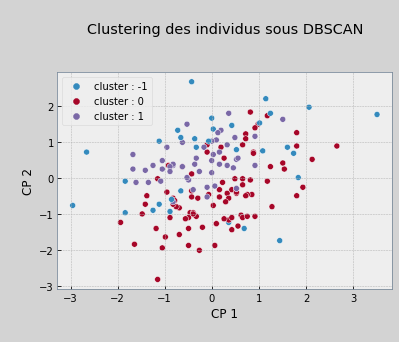

In [78]:
# projection des individus
sns.scatterplot(
    x_dbscan[:, 0], x_dbscan[:, 1],
    hue = ["cluster : {}".format(l) for l in labels],
   # palette = sns.color_palette("rocket", as_cmap = True),
    )

# infos. d'usage
plt.xlabel("CP 1\n")
plt.ylabel("\nCP 2")
plt.title("\nClustering des individus sous DBSCAN\n\n")
plt.savefig("clustering_dbscan", dpi = 500)

Nous avons 3 clusters.  
- C -1: correspond aux individus assimilés à du bruit, ie outliers;  
- C 1 et C2 sont les deux ensembles que nous recherchions à travers cette classification automatique, leur différenciation n'est pas prononcé mais l'amas globale montre clairement une bipolarité dont les pôles sont les clusters.

In [79]:
# expression des individus en fonction des composantes de DBSCAN
dbscan_ind_ = pd.DataFrame(x_dbscan, columns = ["f" + str(i+1) for i in range(6)])

In [80]:
# expression des indidvidus en fonctions des 2 premières composantes
dbscan_ind = dbscan_ind_.iloc[:, :2]

In [81]:
# préparation des colonnes du nouveau df
colonnes_dbscan = data.drop("contrefait", axis = 1)

In [82]:
# expression des composantes dbscan en fonction des variables
dbscan_variables = pd.DataFrame(db.components_, columns = colonnes_dbscan.columns, index = ['core_' + str(i+1) for i in range(len(db.components_))])

In [83]:
dbscan_variables

,diagonale,hauteur_gc,hauteur_dt,marge_inf,marge_sup,largeur
core_1,-0.887559,-1.097697,-0.691254,-0.860126,-1.274740,0.780697
core_2,-0.362742,-1.030427,-0.509439,-0.303010,-1.232307,1.377405
core_3,-0.461145,-0.963156,-0.842767,-1.260106,-0.213913,1.149571
core_4,-1.182769,-1.400415,-1.691238,-1.531521,0.083119,0.878340
core_5,0.654093,0.920419,0.823873,0.025545,-0.638244,-0.108939
...,...,...,...,...,...,...
core_110,-0.526747,0.012267,0.702662,1.654036,0.549883,-1.410846
core_111,-1.674786,0.651337,0.126914,1.596896,-0.129047,-0.814138
core_112,0.555689,0.550431,1.581436,0.896930,1.738009,-0.857535
core_113,-0.395543,-0.324086,-0.145809,0.168395,1.610710,-0.759892


#### [**4. Mission 3 - modélisation**](#table-des-matières)  
  
Nous cherchons à créer un modéle permettant de déterminer si un billet est vrai ou faux. Il s'agit de deux états pouvant être caractérisés par des valeurs booléennes, respectivement, 1 et 0.  
Puisque nous cherchons à déterminer un comportement bipolaire, nous choississons d'utiliser un modèle reposant sur la régression logistique.  
  
Cette partie se fait en deux temps:  
o 4.1. Construction du modèle;  
o 4.2 Utilisation et évaluation du modéle.  
    
##### [**4.1 Régression logistique**](#table-des-matières)  
  
La construction du modèle se déroule en 2 étapes:  
o Dataset: préparation des données à utiliser;  
o Estimateur-entraînement

##### [o 4.1.1 Dataset](#table-des-matières)  
  
Nous récupérons les données de la BDD principale. Elles sont séparées en deux catégories:  
- y contient la variable à tester "contrefait";  
- x contient tous les features.  
Ensuite, chacune de ces catégories est séparée aléatoirement en deux pour obtenir une partie pour l'entraînement (= 80% des données) et une autre, pour tester le modèle "en interne" (= 20% des données).

In [84]:
# rappel des données
data.shape

(170, 7)

In [85]:
# rappel des variables originelles
data.head(1)

,contrefait,diagonale,hauteur_gc,hauteur_dt,marge_inf,marge_sup,largeur
0,True,171.81,104.86,104.95,4.52,2.89,112.83


In [86]:
# séparation des données features/target
donnees = data.values
x = donnees[:, 1:]
y = donnees[:, 0] # colonne "contrefait"

In [87]:
# préparation des datasets: à_entraîner/à_tester
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = .2, random_state = 0)

In [88]:
# aperçu des dimensions des échantillons
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((136, 6), (34, 6), (136,), (34,))

In [89]:
# redimensionnement des échantillons défectueux
train_y = train_y.reshape(train_y.shape[0], 1).astype('int')
test_y = test_y.reshape(test_y.shape[0], 1).astype('int')

Les dimensions des données sont bonnes et la répartition en groupe d'utilité est faite.

##### [o 4.1.2 Estimateur et entraînement](#table-des-matières)  
  
Nous choississons notre estimateur et l'entraînons sur les données "train_" pour qu'il recherche ses hyperparamètres optimaux.

In [90]:
# création + entraînement du modèle
model = LogisticRegression()
model.fit(train_x, train_y)

c:\workplace\data_env\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Modèle choisi et hyperparamètre en place.

##### [**4.2 Test du modèle**](#table-des-matières)  
  
Déroulement en 3 parties:  
o Utilisation: appliquation du modèle à chaud;  
o Evaluation: mesure du niveau de confiance du modèle;  
o Utilisation in vivo: test in vivo du modèle.

##### [o 4.2.1 Utilisation](#table-des-matières)  
  
- Nous créons des y_prédit ("train_y prédit") en appliquant le modèle sur les test_x;  
- Nous comparons les y_prédits avec les y réelles (aka. test_y).

In [91]:
# calcul de y avec le modèle
y_predit = model.predict(test_x).reshape(test_y.shape[0], 1).astype('int')
y_predit.shape

(34, 1)

In [93]:
# affichage des prédictions
prediction = pd.DataFrame(data = np.hstack((y_predit, test_x)), columns = data.columns)
prediction

,contrefait,diagonale,hauteur_gc,hauteur_dt,marge_inf,marge_sup,largeur
0,0,171.69,104.17,104.37,5.31,3.54,111.89
1,0,171.69,103.87,104.16,5.46,3.31,111.42
2,0,171.82,103.97,103.88,4.73,3.55,111.87
3,1,171.62,103.49,103.58,3.95,3.0,113.1
4,1,172.53,103.99,103.55,4.5,3.1,113.03
5,0,171.56,103.8,103.87,5.66,2.98,112.95
6,1,171.58,103.65,103.37,3.54,3.19,113.38
7,1,172.0,104.32,104.26,4.53,3.04,112.93
8,0,172.07,104.5,104.23,6.19,3.07,111.21
9,1,171.49,103.77,103.6,4.01,3.09,112.95


##### [o 4.2.2 Evaluation](#table-des-matières)  
  
En fonction des différences entre les y empiriques et réelles, est calculé le coefficient de détermination (aka un score) du modèle pour déterminer son efficacité.

In [94]:
# calcul du degré de confiance du modèle
score = model.score(test_x, test_y)
print("Score du modèle:", score)

Score du modèle: 1.0


Le coefficient de détermination = 1 => degré de confiance du modèle = 100% => modèle = décrit parfaitement le comportement des données => la perfection est de ce monde...

In [95]:
# comparaison entre les y empiriques et théoriques
resultat = confusion_matrix(test_y, y_predit)
print(resultat)

[[14  0]
 [ 0 20]]


=> Nous obtenons 14 prédictions pour l'état 0 et 20 prédictions pour l'état 1;  
=> Nombres correspondant aux états de test_y;  
=> Notre modèle n'a pas fait d'erreur et décrit parfaitement le comportement des données.

##### [o 4.2.3 Utilisation in vivo](#table-des-matières)  
  
- Nous mettons un coup de vernis sur le modèle afin de rendre l'affichage de son résultat facilement lisible sur n'importe quel dataset. Pour cela, nous créons une fonction qui prend en entrée le modèle et un dataset puis retourne un dataframe avec une colonne "contrefait" et les probabilités inhérentes;  
- Nous appliquons le modèle sur un jeu de données test.

In [96]:
# fonction d'utilisation du modèle
def vrai_faux(model, dataset):

    # préparation des données
    id = dataset.id # sauvegarde des Id
    x = dataset.drop('id', axis = 1).values

    # application du modèle
    resultat_ = model.predict(x).reshape(x.shape[0], 1).astype('int') # redimension du résultat

    # travail sur la présentation des résultats
    donnee = np.hstack((x, resultat_)) # réunion des prédictions et des valeurs
    resultat = pd.DataFrame(data = donnee, columns = dataset.columns, index = id)
    resultat.rename(columns = {'id':'contrefait'}, inplace = True)
    resultat['probabilite_etat_0'] = model.predict_proba(x)[:, 0] * 100
    resultat['probabilite_etat_1'] = model.predict_proba(x)[:, 1] * 100
    
    return resultat

Nous utilisons le modèle sur un nouvel échantillon de données afin de tester son comportement.

In [97]:
# extraction des données à tester
billet_test = pd.read_csv('datatest.csv')

In [98]:
# test du dataset
vrai_faux(model, billet_test)

,diagonal,height_left,height_right,margin_low,margin_up,length,contrefait,probabilite_etat_0,probabilite_etat_1
id,,,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,0.0,94.899375,5.100625
A_2,171.87,104.17,104.13,6.00,3.31,112.09,0.0,98.637348,1.362652
A_3,172.00,104.58,104.29,4.99,3.39,111.57,0.0,96.575782,3.424218
A_4,172.49,104.55,104.34,4.44,3.03,113.20,1.0,13.267566,86.732434
A_5,171.65,103.63,103.56,3.77,3.16,113.33,1.0,0.470636,99.529364


=> Le modèle est capable de prendre en entrée un jeu de données contenant les caractéristiques de billets et d'estimer si les targets sont des faux ou de vrais billets ainsi que de fournir une probabilité sur ses décisions.  
=> Le modèle est prêt à être exploité.

In [104]:
test = pd.read_csv('test_notes.csv')

In [105]:
vrai_faux(model, test)

,diagonal,height_left,height_right,margin_low,margin_up,length,contrefait,probabilite_etat_0,probabilite_etat_1
id,,,,,,,,,
B_1,172.09,103.95,103.73,4.39,3.09,113.19,1.0,4.633827,95.366173
B_2,171.52,104.17,104.03,5.27,3.16,111.82,0.0,92.781875,7.218125
B_3,171.78,103.80,103.75,3.81,3.24,113.39,1.0,0.715322,99.284678
B_4,172.02,104.08,103.99,5.57,3.30,111.10,0.0,99.407462,0.592538
B_5,171.79,104.34,104.37,5.00,3.07,111.87,0.0,89.649134,10.350866
